In [ ]:
IST1100266 Saúl Sandinha Gomes - https://github.com/SaulSandinha/Assignment-2-sistemas-inteligentes

## ANFIS - Regressão

In [91]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


This section loads and prepares the dataset for the model:

Dataset choice: The code selects a regression dataset (diabetes from scikit-learn).

Feature extraction: X contains the input features as a NumPy array.

Target extraction: y contains the output values (continuous targets for regression).


In [92]:
# CHOOSE DATASET

# Regression dataset
data = datasets.load_diabetes(as_frame=True)

# Classification dataset
#data = datasets.fetch_openml("diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 

# Converter labels em binário (0 = negativo, 1 = positivo) (só usado em classification)
#y= np.array([1 if val == "tested_positive" else 0 for val in y])

# Converter para tensor PyTorch (coluna) ( só usado em classification)
#y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


X.shape


(442, 10)

This section splits the dataset into training and testing subsets:

Purpose: Separating the dataset ensures that the model is evaluated on unseen data, providing a realistic estimate of generalization performance and preventing overfitting.

test_size = 0.2: Allocates 20% of the dataset to testing and 80% to training, a common split ratio that balances training data volume and evaluation reliability.

Random state: Setting random_state=42 ensures reproducibility of the split, so results remain consistent across runs.

In [93]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

This section standardizes the input features to improve model performance:

Purpose: Standardization rescales features to have zero mean and unit variance, which helps improve convergence speed and stability in gradient-based learning algorithms.

fit_transform on training data: Learns the scaling parameters (mean and standard deviation) from the training set and applies the transformation.

transform on test data: Uses the same scaling parameters learned from the training set to ensure consistent feature representation and avoid data leakage.

Standardizing features is a fundamental preprocessing step, particularly important for models sensitive to feature scale.

In [94]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


This section applies Fuzzy C-Means (FCM) to the training data. Unlike k-means, FCM assigns each sample a degree of membership to each cluster, which is useful when classes overlap.

Parameters: n_clusters = 2 (binary setting), m = 2 (controls fuzziness; higher → softer memberships).

Preprocessing: Features Xtr are concatenated with labels ytr into Xexp, then transposed since skfuzzy expects input as features × samples.

Outputs: centers (cluster centroids), u (membership matrix), and fpc (partition coefficient, measures clustering quality).

In short, this step performs a soft clustering that models uncertainty by allowing points to partially belong to multiple clusters.

In [ ]:
 # Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [96]:
centers.shape

(2, 11)

In [97]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.8556210024955945


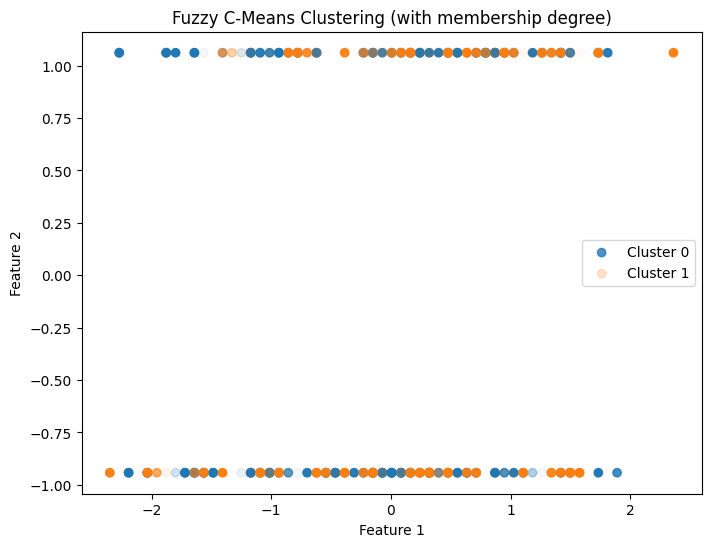

In [98]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

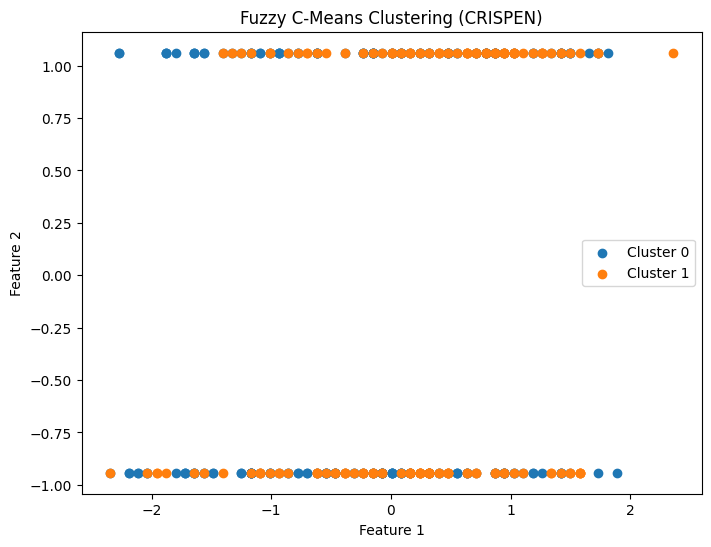

In [99]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

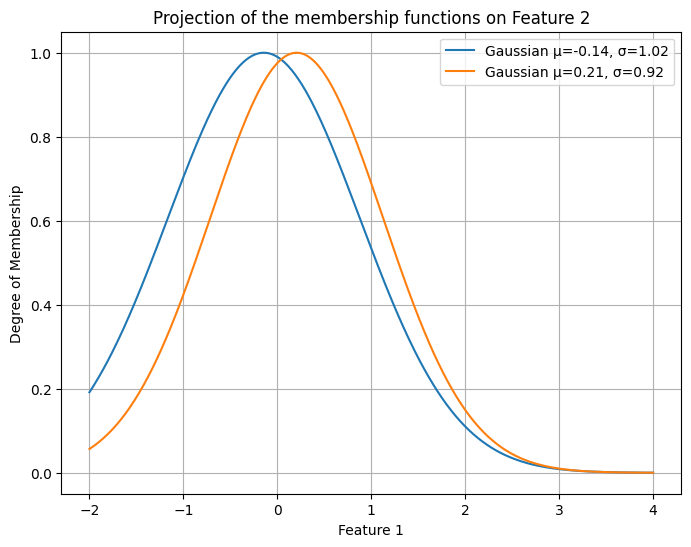

In [100]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [101]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [102]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [103]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optimizer.step()


This function implements the hybrid learning algorithm for ANFIS, which alternates between gradient descent (GD) and least squares (LS):

Step A (GD): Update the antecedent parameters (membership functions) while freezing the consequents. This tunes the fuzzy sets to better represent the input space.

Step B (LS): Update the consequent parameters (linear coefficients) using least squares, while keeping the antecedents fixed. This ensures optimal rule outputs given the current fuzzy partitions.

By alternating these two steps for several iterations, the model combines the flexibility of GD with the efficiency of LS, achieving faster and more stable convergence than using GD alone.

In [104]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [105]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [106]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32).reshape(-1,1)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32).reshape(-1,1)


In [107]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr, max_iters=10, gd_epochs=20, lr=1e-3)


In [108]:
y_pred, _, _=model(Xte)
#performance metric for classification
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#performance metric for regression
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2655.36083984375


## Redes Neuronais - Regressão

In [21]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

This section loads and prepares the dataset for the model:

Dataset choice: The active line loads a regression dataset (diabetes from scikit-learn). The commented section provides an alternative option for a classification task.

Feature extraction: X stores the input features as a NumPy array, representing the predictor variables.

Target extraction: y stores the target variable values, which are continuous in the regression case.

Shape inspection: X.shape verifies the dimensions of the feature matrix, ensuring correct dataset structure before proceeding.

In [22]:
# CHOOSE DATASET

# Regression dataset
data = datasets.load_diabetes(as_frame=True)

# Classification dataset
#data = datasets.fetch_openml("diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 
X.shape

(442, 10)

In [23]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [24]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

This class defines a fully connected neural network for regression/classification. The architecture consists of four hidden layers with 128 neurons each, followed by an output layer.

Hidden layers: Each linear layer is followed by a ReLU activation, introducing non-linearity.

Dropout: Applied after each hidden layer (p=0.5) to reduce overfitting by randomly deactivating neurons during training.

Output layer: Maps the final hidden representation to the desired output dimension (default = 1).

Overall, this deep MLP captures complex input–output relationships while dropout regularization helps improve generalization.

In [25]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

The following hyperparameters control the training process:

num_epochs = 500: Number of complete passes through the training dataset, allowing the model sufficient iterations to converge.

lr = 0.00025: Learning rate for gradient-based optimization. A small value ensures stable updates and avoids overshooting minima.

dropout = 0.05: Low dropout probability, meaning most neurons are retained. This provides slight regularization without heavily reducing model capacity.

batch_size = 64: Number of samples per gradient update, balancing computational efficiency and gradient stability.

These values jointly define the trade-off between convergence speed, stability, and generalization performance.

In [26]:
num_epochs=500
lr=0.00025
dropout=0.05
batch_size=64

In [27]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

This section prepares the model for training:

Model instantiation: Creates an MLP with input size matching the feature dimension of Xtr and the specified dropout rate. The model is moved to the selected device for computation.

Loss function: Uses Mean Squared Error (MSE), appropriate for regression tasks. 

Optimizer: Adam optimizer is chosen for its adaptive learning rate and efficient convergence, with learning rate set by lr.

In [28]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
#criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

This block implements the iterative training process for the MLP:

Epoch loop: Repeats the training process num_epochs times to allow the model to progressively learn patterns in the data.

Batch processing: Training data is processed in batches (batch_size = 64), improving computational efficiency and providing smoother gradient estimates.

Forward pass: The model computes predictions (logits) for the current batch.

Loss computation: Calculates the discrepancy between predictions and ground truth using the chosen loss function (criterion).

Backward pass: Gradients are computed via backpropagation, and the optimizer updates model parameters accordingly.

Loss tracking: The average loss per epoch is computed and printed, providing insight into training convergence.

This loop embodies the core supervised learning procedure, iteratively refining model parameters to minimize the loss function.

In [29]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/500], Loss: 29438.4925
Epoch [2/500], Loss: 29268.9616
Epoch [3/500], Loss: 29619.7917
Epoch [4/500], Loss: 29000.3421
Epoch [5/500], Loss: 29456.8353
Epoch [6/500], Loss: 29823.8522
Epoch [7/500], Loss: 29636.6051
Epoch [8/500], Loss: 29275.9593
Epoch [9/500], Loss: 29357.8249
Epoch [10/500], Loss: 28433.1009
Epoch [11/500], Loss: 26363.3385
Epoch [12/500], Loss: 26054.6383
Epoch [13/500], Loss: 24292.2386
Epoch [14/500], Loss: 21670.8688
Epoch [15/500], Loss: 18251.5378
Epoch [16/500], Loss: 14319.1774
Epoch [17/500], Loss: 11059.0828
Epoch [18/500], Loss: 8366.9289
Epoch [19/500], Loss: 6435.3175
Epoch [20/500], Loss: 5556.5446
Epoch [21/500], Loss: 5172.9698
Epoch [22/500], Loss: 4834.4103
Epoch [23/500], Loss: 4475.1899
Epoch [24/500], Loss: 4315.3626
Epoch [25/500], Loss: 4441.7754
Epoch [26/500], Loss: 4152.5026
Epoch [27/500], Loss: 3959.4728
Epoch [28/500], Loss: 3958.5800
Epoch [29/500], Loss: 3798.0827
Epoch [30/500], Loss: 3810.9907
Epoch [31/500], Loss: 4009.1216


In [30]:
model.eval()
y_pred=model(Xte)
#print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

MSE:2760.140869140625


## ANFIS - Classificação

In [37]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


Dataset Selection and Preparation

This section loads and prepares the dataset for training:

Dataset choice: The code selects a classification dataset (diabetes from OpenML).

Feature and label extraction: X contains input features, y contains target labels.

Binary encoding: For classification, labels are converted to binary values (0 = negative, 1 = positive) to suit supervised learning.

Tensor conversion: Labels are converted into PyTorch tensors with shape (n_samples, 1) for compatibility with the model.

The binary encoding, and tensor conversion is not needed when dealing with regression, where the labels are continuous target values, but is necessary in classification.

In [38]:
# CHOOSE DATASET

# Regression dataset
#data = datasets.load_diabetes(as_frame=True)

# Classification dataset
data = datasets.fetch_openml("diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 

# Converter labels em binário (0 = negativo, 1 = positivo) (só usado em classification)
y= np.array([1 if val == "tested_positive" else 0 for val in y])

# Converter para tensor PyTorch (coluna) ( só usado em classification)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


X.shape


(768, 8)

In [39]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [40]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


In [41]:
 # Number of clusters 
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)
#Xexp=Xtr

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T 

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [42]:
centers.shape

(2, 9)

In [43]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

Fuzzy partition coefficient (FPC): 0.5049376838853796


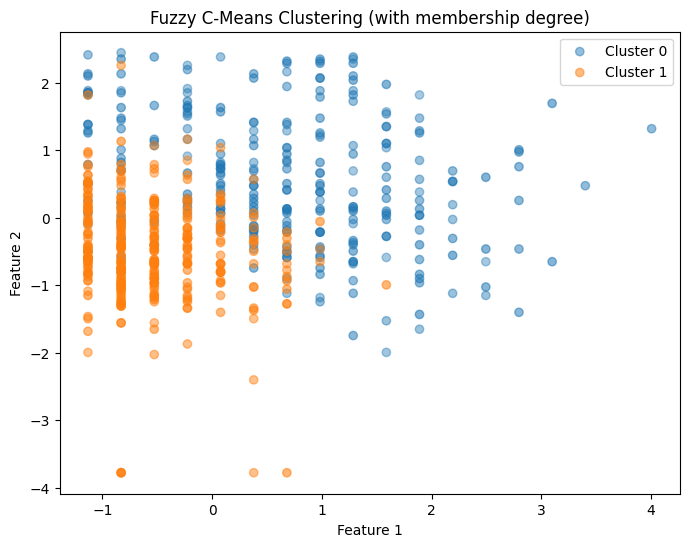

In [44]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

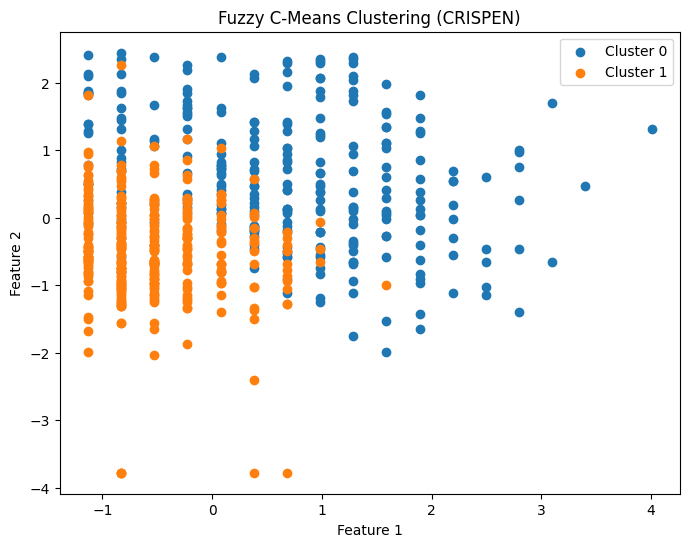

In [45]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

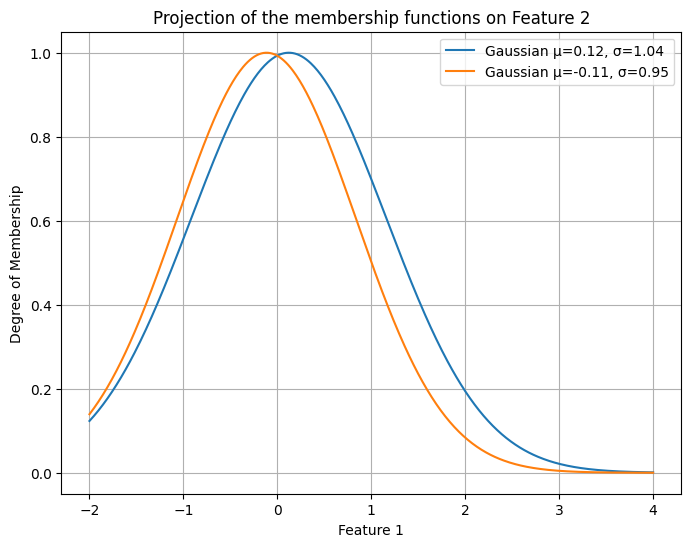

In [46]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
feature=0
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,feature], sigmas[j,feature]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,feature],2)}, σ={np.round(sigmas[j,feature],2)}")

plt.title("Projection of the membership functions on Feature 2")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)
        
        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)
        
        self.mfs=GaussianMF(centers, sigmas,agg_prob) 

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]
        
        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)
        
        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



In [48]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)
        
        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)
        
        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y
        
        theta= torch.linalg.lstsq(Phi, y).solution
    
        
        model.consequents.data = theta.reshape(model.consequents.shape)

    


In [49]:
# ---------------------------
# Gradient Descent Training 
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        #print(loss)
        loss.backward()
        optimizer.step()


In [50]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True

In [51]:
# ---------------------------
# Alternative Hybrid Training (LS+ gradient descent on all)
# ---------------------------
def train_hybrid(model, X, y, epochs=100, lr=1e-4):
    # Step 1: LS for consequents
    train_ls(model, X, y)
    # Step 2: GD fine-tuning
    train_gd(model, X, y, epochs=epochs, lr=lr)


In [52]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32).reshape(-1,1)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32).reshape(-1,1)


C:\Users\Murtaghy\AppData\Local\Temp\ipykernel_15480\1902815775.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32).reshape(-1,1)
C:\Users\Murtaghy\AppData\Local\Temp\ipykernel_15480\1902815775.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yte = torch.tensor(yte, dtype=torch.float32).reshape(-1,1)


In [53]:
# Training with LS:
train_hybrid_anfis(model, Xtr, ytr, max_iters=10, gd_epochs=20, lr=1e-3)


In [54]:
y_pred, _, _=model(Xte)
#performance metric for classification
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#performance metric for regression
#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7402597402597403


## Redes Neuronais - Classificação

In [105]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

This section loads and prepares the dataset for the model:

Dataset selection: The commented line offers a regression example (load_diabetes), while the active code uses a classification dataset (diabetes from OpenML).

Feature extraction: X contains the input features as a NumPy array.

Target extraction: y contains the raw labels.

Binary encoding: For classification tasks, labels are converted into binary format (0 = negative, 1 = positive) to suit supervised learning.

Tensor conversion: Labels are converted to PyTorch tensors with shape (n_samples, 1), ensuring compatibility with the neural network.


In [106]:
# CHOOSE DATASET

# Regression dataset
#data = datasets.load_diabetes(as_frame=True)

# Classification dataset
data = datasets.fetch_openml("diabetes",version=1, as_frame=True) 

X = data.data.values
y = data.target.values 

# Converter labels em binário (0 = negativo, 1 = positivo) (só usado em classification)
y= np.array([1 if val == "tested_positive" else 0 for val in y])

# Converter para tensor PyTorch (coluna) ( só usado em classification)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


X.shape

(768, 8)

In [107]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [108]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [109]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size=1, dropout_prob=0.5):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.out = nn.Linear(64, output_size)
        
        self.dropout = nn.Dropout(p=dropout_prob)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        
        x = self.out(x)
        return x

In [110]:
num_epochs=100
lr=0.00025
dropout=0.1
batch_size=64

In [111]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)

# Wrap Xtr and ytr into a dataset
train_dataset = TensorDataset(Xtr, ytr)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\Murtaghy\AppData\Local\Temp\ipykernel_17000\3341141645.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ytr = torch.tensor(ytr, dtype=torch.float32)
C:\Users\Murtaghy\AppData\Local\Temp\ipykernel_17000\3341141645.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yte = torch.tensor(yte, dtype=torch.float32)


In [112]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLP(input_size=Xtr.shape[1], dropout_prob=dropout).to(device)
criterion = nn.BCEWithLogitsLoss()  # for binary classification
criterion = nn.MSELoss() #for regression
optimizer = optim.Adam(model.parameters(), lr=lr)

In [113]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = criterion(logits, batch_y.view(-1, 1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/100], Loss: 0.2716
Epoch [2/100], Loss: 0.2480
Epoch [3/100], Loss: 0.2309
Epoch [4/100], Loss: 0.2135
Epoch [5/100], Loss: 0.2027
Epoch [6/100], Loss: 0.1948
Epoch [7/100], Loss: 0.1877
Epoch [8/100], Loss: 0.1765
Epoch [9/100], Loss: 0.1717
Epoch [10/100], Loss: 0.1659
Epoch [11/100], Loss: 0.1676
Epoch [12/100], Loss: 0.1665
Epoch [13/100], Loss: 0.1620
Epoch [14/100], Loss: 0.1599
Epoch [15/100], Loss: 0.1559
Epoch [16/100], Loss: 0.1575
Epoch [17/100], Loss: 0.1509
Epoch [18/100], Loss: 0.1586
Epoch [19/100], Loss: 0.1562
Epoch [20/100], Loss: 0.1522
Epoch [21/100], Loss: 0.1603
Epoch [22/100], Loss: 0.1532
Epoch [23/100], Loss: 0.1576
Epoch [24/100], Loss: 0.1461
Epoch [25/100], Loss: 0.1510
Epoch [26/100], Loss: 0.1503
Epoch [27/100], Loss: 0.1491
Epoch [28/100], Loss: 0.1480
Epoch [29/100], Loss: 0.1485
Epoch [30/100], Loss: 0.1470
Epoch [31/100], Loss: 0.1454
Epoch [32/100], Loss: 0.1447
Epoch [33/100], Loss: 0.1517
Epoch [34/100], Loss: 0.1474
Epoch [35/100], Loss: 0

In [114]:
y_pred=model(Xte)
print(f'ACC:{accuracy_score(yte.detach().numpy(),y_pred.detach().numpy()>0.5)}') #classification
#print(f'MSE:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}') #regression

ACC:0.7337662337662337
